<a href="https://colab.research.google.com/github/BelKaty/BelKatyParsing/blob/main/HW7_selenium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Устанавливаем пакеты если они не установлены
# !pip install selenium
# !pip install pandas
# !pip install matplotlib
# !pip install pymongo

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
options = Options()
# Запуск браузера с развернутым экраном
options.add_argument('start-maximized')
# Будем использовать браузер Chrome
driver = webdriver.Chrome(options=options)
# Открываем ссылку
driver.get('https://www.wildberries.ru/')
time.sleep(4)

In [ ]:
wait = WebDriverWait(driver, 10)
# Ищем строку поиска
input = wait.until(EC.presence_of_element_located((By.ID, "searchInput")))
# Вводим фразу поиска и нажимаем Enter
input.send_keys('аккумулятор для ибп 12v')
input.send_keys(Keys.ENTER)

### Прокручиваем страницу и записываем все ссылки на аккумуляторы, если есть кнопка "далее" - нажимаем её или выходим из цикла

In [ ]:
# Список ссылок на страницы аккумулятора
url_list = []

while True:
    # Количество аккумуляторов на странице
    count = None
    while True:
        time.sleep(4)
        # Ожидаем появление объекта (html код) карточек товара
        cards = wait.until(EC.presence_of_all_elements_located((By.XPATH, '//article[@id]')))
        # Выходим из цикла, если при прокрутке страницы, количество товаров не меняется
        if len(cards) == count:
            break
        # Вычисляем сколько карточек товара на странице
        count = len(cards)
        # Прокручиваем страницу выполняя JAVA Script
        driver.execute_script('window.scrollBy(0, 1800)')
        time.sleep(2)

    # На полностью загруженной странице соберём инфу
    for card in cards:
        # Записываем ссылку каждого аккумулятора
        url = card.find_element(By.XPATH, './div/a').get_attribute('href')
        url_list.append(url)

    # Проверяем есть ли кнопка дальше
    try:
        next = driver.find_element(By.XPATH,  "//a[@class='pagination-next pagination__next j-next-page']")
        next.click()
    except Exception:
        break

In [ ]:
print(f'Всего получено: {len(url_list)} ссылок на аккумуляторы')

Всего получено: 970 ссылок на аккумуляторы


### Заходим на каждую страницу найденныж аккомуляторов и парсим её

In [ ]:
driver2 = webdriver.Chrome(options=options)
wait2 = WebDriverWait(driver2, 10)
acb_list = []

# Просматриваем все ссылки ан аккумуляторы
for url_item in url_list:
    acb_dict = {}

    driver2.get(url_item)
    # Заносим назание аккумулятора
    acb_dict['name'] = wait2.until(EC.presence_of_element_located((By.XPATH, "//h1"))).text
    # Заносим цену аккумулятора
    price = wait2.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'price-block__wallet-price')))
    try:
        acb_dict['price'] = float(re.sub(r'[^\d.]+', '', price[1].text))
    except Exception:
        acb_dict['price'] = None
    # Заносим бренд аккумулятора
    acb_dict['brend'] = wait2.until(EC.presence_of_element_located((By.CLASS_NAME, "product-page__header-brand"))).text
    # Заносим url ссылку на аккумулятор
    acb_dict['url'] = url_item

    # Обрабатываем табличные данные
    table_label = wait2.until(EC.presence_of_all_elements_located((By.XPATH, '//th')))
    table_param = wait2.until(EC.presence_of_all_elements_located((By.XPATH, '//td')))
    # Заносим данные в зависимости от названия
    for i in range(len(table_label)):
        if table_label[i].text == 'Страна производства':
            acb_dict['country'] = table_param[i].text
        elif table_label[i].text == 'Емкость аккумулятора (Ач)':
            try:
                val = table_param[i].text.strip()
                val, *_ = val.split()
                acb_dict['capacity'] = float(re.sub(r'[^\d.]+', '', val))
            except Exception:
                acb_dict['capacity'] = None
        elif table_label[i].text == 'Напряжение':
             try:
                val = table_param[i].text.strip()
                val, *_ = val.split()
                acb_dict['voltage'] = float(re.sub(r'[^\d.]+', '', val))
             except Exception:
                acb_dict['voltage'] = None

    # Добавляем словарь в список аккумуляторов
    acb_list.append(acb_dict)

In [ ]:
print(f'Обработано {len(acb_list)} страниц')

Обработано 970 страниц


### Посмотрим, что за данные мы получили

In [ ]:
df = pd.DataFrame(acb_list)
df.head()

,name,price,brend,url,country,capacity,voltage
0,"Аккумулятор SF 1207, 7Ач, аккумуляторная батар...",758.00,Security Force,https://www.wildberries.ru/catalog/40724205/de...,Китай,7.00,12.00
1,Аккумулятор 12v 7ah акб agm 1207,1097.00,SKAT,https://www.wildberries.ru/catalog/149737382/d...,Китай,7.00,12.00
2,Аккумулятор Yellow VL 12-7.5 для детского элек...,1643.00,YELLOW,https://www.wildberries.ru/catalog/161312115/d...,Китай,7.50,12.00
3,Аккумулятор для ибп 12v 7 Ah F1/T1 осветительн...,959.00,Thomas,https://www.wildberries.ru/catalog/194125712/d...,Китай,7.00,12.00
4,Аккумулятор 12в 7ач GP-S 12-7,1179.00,ЭТК Энергия,https://www.wildberries.ru/catalog/216797039/d...,Китай,7.00,12.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      970 non-null    object 
 1   price     970 non-null    float64
 2   brend     970 non-null    object 
 3   url       970 non-null    object 
 4   country   830 non-null    object 
 5   capacity  836 non-null    float64
 6   voltage   839 non-null    float64
dtypes: float64(3), object(4)
memory usage: 53.2+ KB


### Какие производители аккумуляторов для ИБП представлены на Wildberries

In [ ]:
data = df['country'].value_counts()
names = data.index
values = data.values
data

country
Китай      779
Вьетнам     40
Тайвань      7
Россия       4
Name: count, dtype: int64

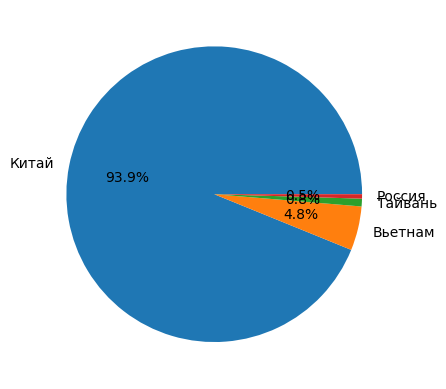

In [ ]:
plt.pie(values, autopct='%.1f%%', labels=names)
plt.show()

### Минимальная, максимальная и средняя цена аккумулятора в зависимости от его ёмкости

In [ ]:
df.groupby('capacity').agg({'price': ['min', 'mean', 'max']})

price                  
              min     mean      max
capacity                           
0.80       550.00   890.44  1035.00
1.20       430.00   670.19  1036.00
1.30       577.00   790.30  1286.00
2.20       594.00   875.75  1239.00
2.30       670.00   842.73  1565.00
2.80       776.00   784.00   792.00
2.90      1023.00  1023.00  1023.00
3.20       774.00  1227.87  1780.00
3.30      1228.00  1351.00  1474.00
4.50       532.00  1238.20  3184.00
5.00       795.00  1643.71  4100.00
5.40      1154.00  1205.50  1257.00
5.50      2004.00  2076.50  2149.00
5.80      1164.00  1829.00  2303.00
6.00      1228.00  2061.71  2750.00
7.00       701.00  1311.90  4684.00
7.20       636.00  1723.51  4338.00
7.50      1215.00  1865.50  3170.00
8.00       574.00  1779.50  3237.00
8.60      1755.00  1755.00  1755.00
9.00      1106.00  2022.26  4902.00
10.00     1134.00  1134.00  1134.00
12.00      601.00  2660.12  7257.00
13.00      566.00  1396.00  2766.00
14.00     2040.00  2040.00  2040.00
15.00     2268.00  4229.83  6413.00
17.00     1973.00  4493.83  9487.00
18.00     1972.00  3532.81  8068.00
20.00     2701.00  5257.67  7801.00
22.00      641.00  1750.70  4630.00
23.00      700.00   700.00   700.00
24.00    10164.00 10164.00 10164.00
26.00     2695.00  5478.86 10537.00
28.00     1986.00  4606.55 11212.00
30.00    11212.00 11212.00 11212.00
32.00      847.00   847.00   847.00
33.00     1363.00  7514.86 14392.00
34.00    11696.00 11696.00 11696.00
35.00      626.00   626.00   626.00
36.00     5934.00  5934.00  5934.00
38.00     7501.00  7506.00  7511.00
40.00     4174.00  7981.55 15784.00
45.00      915.00  8684.90 17087.00
50.00     7288.00 13553.17 17213.00
55.00     1009.00 14616.90 22349.00
60.00     8817.00  8817.00  8817.00
65.00     6188.00 14867.47 25857.00
70.00    13545.00 13545.00 13545.00
72.00      795.00  1675.45  3523.00
75.00     1584.00 16827.29 31196.00
80.00     9596.00 12153.33 17072.00
90.00    14728.00 14728.00 14728.00
100.00   14431.00 16425.50 21799.00
120.00   16210.00 16375.50 16541.00
150.00   19786.00 19786.00 19786.00
200.00   26710.00 30122.00 33534.00
5000.00   1474.00  1474.00  1474.00
40000.00 11113.00 11113.00 11113.00

### Топ 10 популярных компаний

In [ ]:
data = df['brend'].value_counts()
names = data.index
values = data.values
data.head(10)

brend
DELTA BATTERY       195
General Security     66
Kiper Power          54
LEOCH                45
Alfa Battery         39
NPP                  36
CSB                  36
Security Force       33
Sunways              28
security power       27
Name: count, dtype: int64

### Запишем полученные данные в БД MongoDB

In [ ]:
from pymongo import MongoClient

In [ ]:
# Подключение к серверу MongoDB
client = MongoClient('mongodb://localhost:27017/')
# Выбор базы данных и коллекции
db = client['acb']
collection = db['acb_12v']

In [ ]:
# Отправим данные в БД MongoDB
collection.insert_many(acb_list)

InsertManyResult([ObjectId('6613436589314a54f728e70d'), ObjectId('6613436589314a54f728e70e'), ObjectId('6613436589314a54f728e70f'), ObjectId('6613436589314a54f728e710'), ObjectId('6613436589314a54f728e711'), ObjectId('6613436589314a54f728e712'), ObjectId('6613436589314a54f728e713'), ObjectId('6613436589314a54f728e714'), ObjectId('6613436589314a54f728e715'), ObjectId('6613436589314a54f728e716'), ObjectId('6613436589314a54f728e717'), ObjectId('6613436589314a54f728e718'), ObjectId('6613436589314a54f728e719'), ObjectId('6613436589314a54f728e71a'), ObjectId('6613436589314a54f728e71b'), ObjectId('6613436589314a54f728e71c'), ObjectId('6613436589314a54f728e71d'), ObjectId('6613436589314a54f728e71e'), ObjectId('6613436589314a54f728e71f'), ObjectId('6613436589314a54f728e720'), ObjectId('6613436589314a54f728e721'), ObjectId('6613436589314a54f728e722'), ObjectId('6613436589314a54f728e723'), ObjectId('6613436589314a54f728e724'), ObjectId('6613436589314a54f728e725'), ObjectId('6613436589314a54f728e7

## Вывод:
Взял информацию с сайта `https://www.wildberries.ru/` об аккумуляторах 12V для ИБП. Производится поиск информации, прокрутка страницы, для загрузки всех товаров. Осуществлялся переход по кнопке далее при ее наличии и поиск имеющихся ссылок.
После того как были собраны все ссылки на аккумуляторы, в другом окне браузера открывалась каждая ссылка и извлекались следующие данные:  
- марка;
- напряжение аккумулятора;
- ёмкость аккумулятора;
- бренд;
- страна производитель;
- цена;
- url.
  
В процессе работы был конфликт с версией Chroma.
